# Proyecto YOLOv8: Detección Bicicleta vs Auto

Este cuaderno implementa un flujo sencillo y eficiente (10–15 épocas) para entrenar y evaluar un modelo YOLOv8 que distingue bicicletas y autos, usando datasets en formato YOLO ubicados en `Z_ProyectoYolo/datasets`. Todo está optimizado para Colab o CPU local (Ryzen 5 con gráficos integrados).

In [21]:
# %% [markdown]
# 0) Setup
# - Instala dependencias mínimas si faltan
# - Define variables, fija semilla y detecta dispositivo
# - Crea carpetas de salida

import os, sys, json, random, shutil, math
from pathlib import Path

# Instalación ligera si faltan paquetes
def _ensure(pkg):
    try:
        __import__(pkg)
        return False
    except Exception:
        import subprocess
        print(f"Instalando {pkg}...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)
        return True

_changed = False
for p in ["ultralytics", "opencv-python-headless", "matplotlib", "pandas", "pyyaml"]:
    _changed |= _ensure(p)

import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

# Variables principales (usar rutas relativas robustas)
# Si el cuaderno ya está dentro de Z_ProyectoYolo, usar '.' para evitar duplicar la carpeta en las rutas.
PROJECT_ROOT = "Z_ProyectoYolo"
if Path.cwd().name == "Z_ProyectoYolo":
    PROJECT_ROOT = "."
elif not Path(PROJECT_ROOT).exists():
    # Fallback si se ejecuta desde otro directorio y no existe la carpeta explícita
    PROJECT_ROOT = "."

DATASET_ROOT = f"{PROJECT_ROOT}/datasets"
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

IN_COLAB = "COLAB_GPU" in os.environ or "COLAB_RELEASE_TAG" in os.environ
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Hiperparámetros adaptativos por entorno
if DEVICE == "cuda":
    IMGSZ, EPOCHS, BATCH = 640, 15, 16
    MODEL_BACKBONE = "yolov8s.pt"
else:
    IMGSZ, EPOCHS, BATCH = 512, 12, 4
    MODEL_BACKBONE = "yolov8n.pt"

# Carpetas de salida
RUNS_DIR = f"{PROJECT_ROOT}/runs"
EVAL_DIR = f"{PROJECT_ROOT}/evaluation"
EVAL_FIG_DIR = f"{EVAL_DIR}/figures"
EVAL_METRICS_DIR = f"{EVAL_DIR}/metrics"
INFER_DIR = f"{PROJECT_ROOT}/inference"
INFER_RESULTS_DIR = f"{INFER_DIR}/results_images"
INFER_NEW_IMG_DIR = f"{INFER_DIR}/images_new"
MODEL_OUT_DIR = f"{PROJECT_ROOT}/modelo"

for d in [RUNS_DIR, EVAL_FIG_DIR, EVAL_METRICS_DIR, INFER_RESULTS_DIR, MODEL_OUT_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Info versiones
print({
    "ultralytics": YOLO.__module__.split('.')[0],
    "torch": torch.__version__,
    "device": DEVICE,
    "cwd": str(Path.cwd()),
    "project_root": PROJECT_ROOT,
    "dataset_root": DATASET_ROOT,
    "imgs": IMGSZ,
    "epochs": EPOCHS,
    "batch": BATCH,
    "model": MODEL_BACKBONE,
})

Instalando opencv-python-headless...


Instalando pyyaml...


{'ultralytics': 'ultralytics', 'torch': '2.8.0+cu128', 'device': 'cpu', 'cwd': '/home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo', 'project_root': '.', 'dataset_root': './datasets', 'imgs': 512, 'epochs': 12, 'batch': 4, 'model': 'yolov8n.pt'}


In [22]:
# 1) Objetivo y justificación (breve)

print("Objetivo: Entrenar y evaluar un modelo YOLOv8 para distinguir bicicletas y autos en imágenes.")
print("Justificación: aplicaciones en conteo de tráfico, seguridad y gestión de estacionamientos.")

Objetivo: Entrenar y evaluar un modelo YOLOv8 para distinguir bicicletas y autos en imágenes.
Justificación: aplicaciones en conteo de tráfico, seguridad y gestión de estacionamientos.


In [23]:
# 2) Verificación del dataset (YOLOv8 mínimo) y fusión automática si es necesario
from collections import Counter

# Utilidades para soportar 'val' o 'valid'
def _val_split_name(root: str):
    r = Path(root)
    if (r/"images/val").exists() and (r/"labels/val").exists():
        return "val"
    if (r/"images/valid").exists() and (r/"labels/valid").exists():
        return "valid"
    return None

# Candidatos conocidos
CAND_DATASETS = [
    f"{DATASET_ROOT}/merged_bike_car",
    f"{DATASET_ROOT}/bicycle.v1i.yolov8",
    f"{DATASET_ROOT}/Car.v5-car_4.yolov8",
]

DATASET_PATH = None
VAL_SPLIT = None

# 1) Probar candidatos directos
for cand in CAND_DATASETS:
    vs = _val_split_name(cand)
    if (Path(cand)/"images/train").exists() and (Path(cand)/"labels/train").exists() and vs:
        DATASET_PATH = cand
        VAL_SPLIT = vs
        break

# 2) Búsqueda genérica dentro de datasets/
if DATASET_PATH is None and Path(DATASET_ROOT).exists():
    for p in Path(DATASET_ROOT).glob("**/"):
        vs = _val_split_name(p)
        if (Path(p)/"images/train").exists() and (Path(p)/"labels/train").exists() and vs:
            DATASET_PATH = str(p)
            VAL_SPLIT = vs
            break

# 3) Si no existe conjunto válido, intentar crear uno fusionado bici+auto

def _collect_split_dirs(root: str, split: str):
    return Path(root)/f"images/{split}", Path(root)/f"labels/{split}"

def _remap_and_copy(src_img_dir: Path, src_lab_dir: Path, dst_img_dir: Path, dst_lab_dir: Path, id_map: dict[int,int], prefix: str):
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lab_dir.mkdir(parents=True, exist_ok=True)
    img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"}
    imgs = [p for p in src_img_dir.glob("*") if p.suffix.lower() in img_exts]
    for ip in imgs:
        stem = ip.stem
        lp = src_lab_dir/(stem+".txt")
        new_stem = f"{prefix}_{stem}"
        shutil.copy2(str(ip), str(dst_img_dir/(new_stem+ip.suffix)))
        # Remap labels si existen
        if lp.exists():
            lines_out = []
            for ln in open(lp, "r", encoding="utf-8", errors="ignore").read().strip().splitlines():
                parts = ln.strip().split()
                if len(parts) < 5:
                    continue
                try:
                    cid = int(float(parts[0]))
                except Exception:
                    continue
                cid2 = id_map.get(cid, cid)
                parts[0] = str(cid2)
                lines_out.append(" ".join(parts))
            with open(dst_lab_dir/(new_stem+".txt"), "w", encoding="utf-8") as f:
                f.write("\n".join(lines_out))

if DATASET_PATH is None:
    bike_root = f"{DATASET_ROOT}/bicycle.v1i.yolov8"
    car_root  = f"{DATASET_ROOT}/Car.v5-car_4.yolov8"
    if Path(bike_root).exists() and Path(car_root).exists():
        out_root = f"{DATASET_ROOT}/merged_bike_car"
        # Determinar split válido de cada fuente
        bike_val = _val_split_name(bike_root) or "valid"
        car_val  = _val_split_name(car_root) or "valid"
        # Crear estructura out
        for split_in, split_out in [("train","train"),(bike_val,"val")]:
            src_img, src_lab = _collect_split_dirs(bike_root, split_in)
            dst_img, dst_lab = _collect_split_dirs(out_root, split_out)
            if src_img.exists():
                _remap_and_copy(src_img, src_lab, dst_img, dst_lab, {0:0}, "b")  # bici -> id 0
        for split_in, split_out in [("train","train"),(car_val,"val")]:
            src_img, src_lab = _collect_split_dirs(car_root, split_in)
            dst_img, dst_lab = _collect_split_dirs(out_root, split_out)
            if src_img.exists():
                _remap_and_copy(src_img, src_lab, dst_img, dst_lab, {0:1}, "c")  # auto -> id 1
        # Validar out
        vs = _val_split_name(out_root)
        if (Path(out_root)/"images/train").exists() and (Path(out_root)/"labels/train").exists() and vs:
            DATASET_PATH = out_root
            VAL_SPLIT = vs
            print("Dataset fusionado creado en:", out_root)
        else:
            print("ADVERTENCIA: Falló la creación del dataset fusionado.")

if DATASET_PATH is None:
    raise FileNotFoundError("No se encontró o generó un dataset con estructura YOLOv8 válida en Z_ProyectoYolo/datasets")

print("Usando dataset:", DATASET_PATH, "| split de validación:", VAL_SPLIT)

# Conteo de imágenes por split y verificación de .txt pareados
def _count_images_and_labels(img_dir, lab_dir):
    img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    imgs = [p for p in Path(img_dir).glob("*") if p.suffix.lower() in img_exts]
    missing = []
    for ip in imgs:
        lp = Path(lab_dir)/ (ip.stem + ".txt")
        if not lp.exists():
            missing.append(ip.name)
    return imgs, missing

for split in ["train", VAL_SPLIT]:
    img_dir = f"{DATASET_PATH}/images/{split}"
    lab_dir = f"{DATASET_PATH}/labels/{split}"
    imgs, missing = _count_images_and_labels(img_dir, lab_dir)
    print(f"{split}: {len(imgs)} imágenes, faltan labels para {len(missing)} imágenes")

# Estimar conteo por clase a partir de labels (solo IDs)
class_counts = Counter()
for split in ["train", VAL_SPLIT]:
    for lp in Path(f"{DATASET_PATH}/labels/{split}").glob("*.txt"):
        for ln in open(lp, "r", encoding="utf-8", errors="ignore").read().strip().splitlines():
            if not ln.strip():
                continue
            parts = ln.split()
            try:
                cid = int(float(parts[0]))
                class_counts[cid] += 1
            except Exception:
                pass

print("Instancias por clase (IDs):", dict(class_counts))
if any(v < 50 for v in class_counts.values()):
    print("ADVERTENCIA: Alguna clase tiene <50 instancias; se sugiere recolectar/anotar más datos.")

Usando dataset: ./datasets/merged_bike_car | split de validación: val
train: 370 imágenes, faltan labels para 0 imágenes
val: 54 imágenes, faltan labels para 0 imágenes
Instancias por clase (IDs): {0: 531, 1: 147}


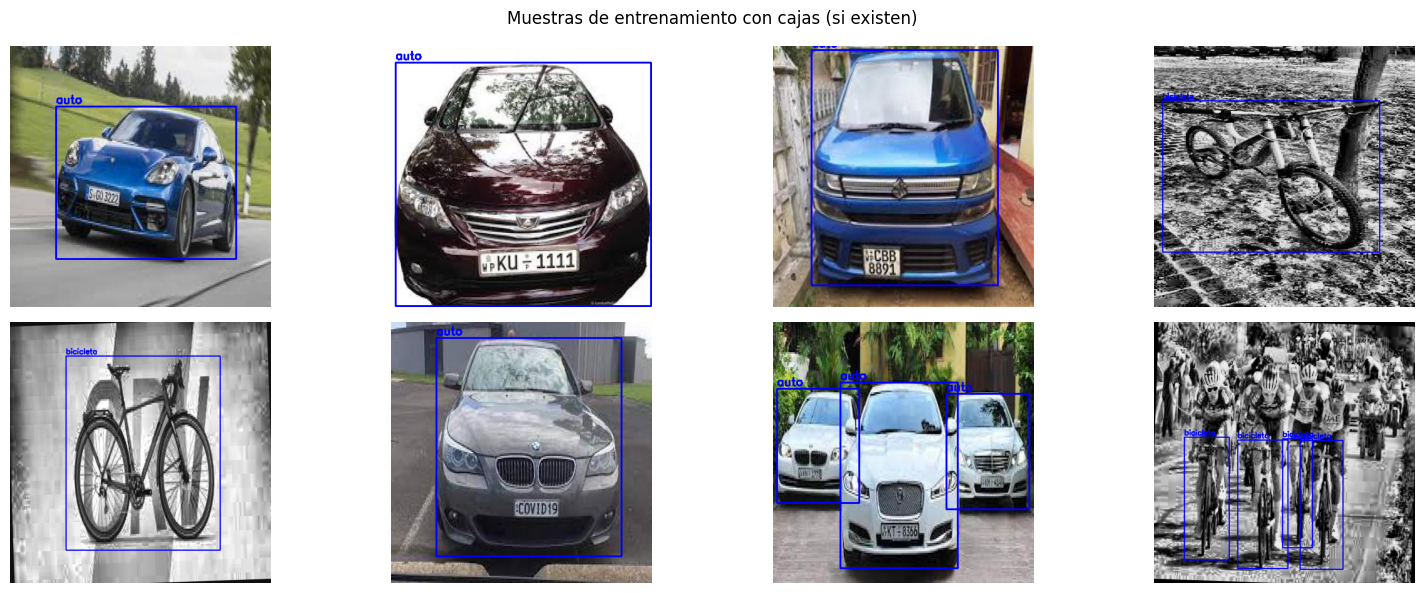

Guardado en: ./evaluation/figures/dataset_samples.png


In [24]:
# 3) Visualización rápida de datos (6–8 ejemplos con boxes)

def _draw_yolo_boxes(img_path, lab_path, class_names={0:'bicicleta',1:'auto'}, color=(255,0,0)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    h, w = img.shape[:2]
    if Path(lab_path).exists():
        for ln in open(lab_path, 'r', encoding='utf-8', errors='ignore').read().strip().splitlines():
            parts = ln.split()
            if len(parts) < 5:
                continue
            cid = int(float(parts[0]))
            cx, cy, bw, bh = map(float, parts[1:5])
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
            label = class_names.get(cid, str(cid))
            cv2.putText(img, label, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Muestreo (entrenamiento)
img_dir = f"{DATASET_PATH}/images/train"
lab_dir = f"{DATASET_PATH}/labels/train"
img_paths = [p for p in Path(img_dir).glob('*') if p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.webp'}]
random.shuffle(img_paths)
sel = img_paths[:8]

cols = 4
rows = math.ceil(len(sel)/cols) if sel else 1
plt.figure(figsize=(4*cols, 3*rows))
for i, ip in enumerate(sel, 1):
    lp = Path(lab_dir)/(Path(ip).stem+".txt")
    img = _draw_yolo_boxes(str(ip), str(lp))
    plt.subplot(rows, cols, i)
    if img is None:
        plt.text(0.5,0.5,'No se pudo cargar', ha='center', va='center')
    else:
        plt.imshow(img); plt.axis('off')
plt.suptitle('Muestras de entrenamiento con cajas (si existen)')
plt.tight_layout()
fig_path = os.path.join(EVAL_FIG_DIR, 'dataset_samples.png')
plt.savefig(fig_path, dpi=150)
plt.show()
print('Guardado en:', fig_path)

In [25]:
# 4) data.yaml (crear si no existe)
DATA_YAML_PATH = f"{PROJECT_ROOT}/data.yaml"
if not Path(DATA_YAML_PATH).exists():
    data_cfg = {
        'train': f"{DATASET_PATH}/images/train",
        # Siempre usaremos la clave 'val' apuntando al split detectado (val o valid)
        'val':   f"{DATASET_PATH}/images/{VAL_SPLIT}",
        'nc': 2,
        'names': ['bicicleta','auto']
    }
    with open(DATA_YAML_PATH, 'w') as f:
        yaml.safe_dump(data_cfg, f, sort_keys=False, allow_unicode=True)
    print('Creado data.yaml en', DATA_YAML_PATH)
else:
    print('Usando data.yaml existente en', DATA_YAML_PATH)

print(open(DATA_YAML_PATH,'r').read())

Usando data.yaml existente en ./data.yaml
train: datasets/merged_bike_car/images/train
val: datasets/merged_bike_car/images/val
nc: 2
names:
- bicicleta
- auto



In [26]:
# 5) Selección del modelo y configuración breve
print(f"Modelo base: {MODEL_BACKBONE} | Dispositivo: {DEVICE} | imgsz={IMGSZ} | epochs={EPOCHS} | batch={BATCH}")
print("Nota: Se prioriza convergencia rápida con pocas épocas. Para GPU potente, considere 'yolov8s.pt'.")

Modelo base: yolov8n.pt | Dispositivo: cpu | imgsz=512 | epochs=12 | batch=4
Nota: Se prioriza convergencia rápida con pocas épocas. Para GPU potente, considere 'yolov8s.pt'.


In [27]:
# 6) Entrenamiento eficiente (10–15 épocas) con early stopping y fallback de batch

cli_cmd = f"yolo detect train model={MODEL_BACKBONE} data={DATA_YAML_PATH} imgsz={IMGSZ} epochs={EPOCHS} batch={BATCH} project={RUNS_DIR} name=exp_bici_auto"
print("Comando reproducible:\n", cli_cmd)

best_path = None
train_success = False
for b in sorted({BATCH, 8, 4, 2}, reverse=True):
    try:
        print(f"\nEntrenando con batch={b} ...")
        model = YOLO(MODEL_BACKBONE)
        results = model.train(
            data=DATA_YAML_PATH,
            imgsz=IMGSZ,
            epochs=EPOCHS,
            batch=b,
            project=RUNS_DIR,
            name='exp_bici_auto',
            device=DEVICE,
            patience=3,          # early stopping corto
            optimizer='AdamW',   # buena convergencia
            cos_lr=True,         # schedule coseno
            workers=2 if DEVICE=='cpu' else 8,
            verbose=True,
        )
        # Localizar best.pt
        for p in Path(RUNS_DIR).rglob('best.pt'):
            if 'exp_bici_auto' in str(p):
                best_path = str(p)
                break
        train_success = True
        break
    except RuntimeError as e:
        if 'out of memory' in str(e).lower():
            print('OOM detectado, reduciendo batch...')
            continue
        else:
            raise e

if not train_success:
    raise RuntimeError('Entrenamiento falló en todos los tamaños de batch')

# Normalizar best.pt a modelo/best.pt
if best_path and Path(best_path).exists():
    Path(MODEL_OUT_DIR).mkdir(parents=True, exist_ok=True)
    shutil.copy2(best_path, os.path.join(MODEL_OUT_DIR, 'best.pt'))
    print('best.pt copiado a', os.path.join(MODEL_OUT_DIR, 'best.pt'))
else:
    print('ADVERTENCIA: No se encontró best.pt')

Comando reproducible:
 yolo detect train model=yolov8n.pt data=./data.yaml imgsz=512 epochs=12 batch=4 project=./runs name=exp_bici_auto

Entrenando con batch=8 ...
New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=./data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, flipl

run_dir: runs/exp_bici_auto


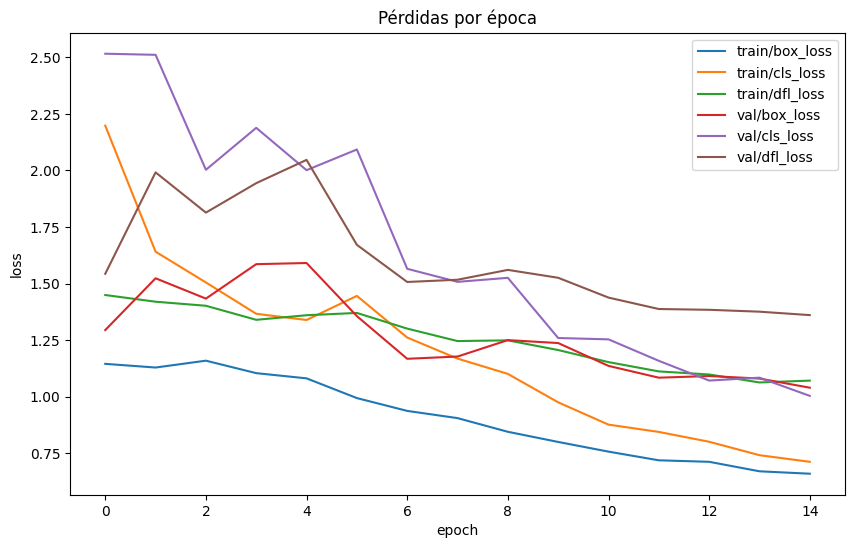

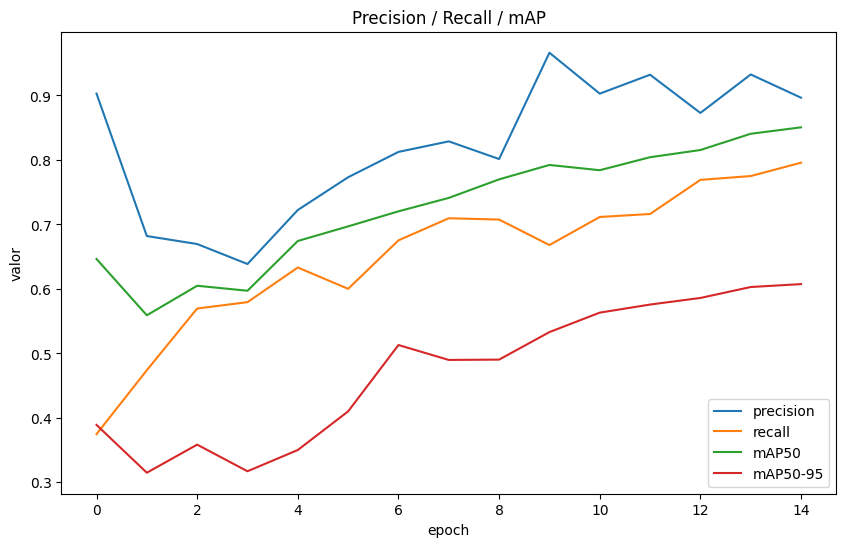

Métricas finales: {'precision': 0.89643, 'recall': 0.79569, 'mAP50': 0.85051, 'mAP50-95': 0.60743}
Guardado metrics.json en ./evaluation/metrics/metrics.json


In [28]:
# 7) Métricas y gráficos (Precision, Recall, mAP@0.5, pérdidas)
# Buscar results.csv y graficar

run_dir = None
for p in Path(RUNS_DIR).glob('**/results.csv'):
    if 'exp_bici_auto' in str(p):
        run_dir = str(p.parent)
        results_csv = str(p)
        break

if run_dir is None:
    raise FileNotFoundError('No se encontró results.csv del entrenamiento')

print('run_dir:', run_dir)
results = pd.read_csv(results_csv)

# Pérdidas
loss_cols = [c for c in results.columns if 'loss' in c.lower()]
plt.figure(figsize=(10,6))
for col in loss_cols:
    plt.plot(results.index, results[col], label=col)
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Pérdidas por época'); plt.legend()
loss_fig = os.path.join(EVAL_FIG_DIR, 'losses.png')
plt.savefig(loss_fig, dpi=150); plt.show()

# PR y mAP
metric_map = {}
for key in ['precision', 'recall', 'mAP50', 'mAP50-95']:
    matches = [c for c in results.columns if key.lower() in c.lower()]
    if matches:
        metric_map[key] = matches[0]

plt.figure(figsize=(10,6))
for k, col in metric_map.items():
    plt.plot(results.index, results[col], label=k)
plt.xlabel('epoch'); plt.ylabel('valor'); plt.title('Precision / Recall / mAP'); plt.legend()
pr_fig = os.path.join(EVAL_FIG_DIR, 'pr_map.png')
plt.savefig(pr_fig, dpi=150); plt.show()

final_metrics = {k: float(results[v].iloc[-1]) for k,v in metric_map.items()}
metrics_json = os.path.join(EVAL_METRICS_DIR, 'metrics.json')
with open(metrics_json, 'w') as f:
    json.dump({'training': {'run_dir': run_dir, 'final_metrics': final_metrics}}, f, indent=2)
print('Métricas finales:', final_metrics)
print('Guardado metrics.json en', metrics_json)

In [ ]:
# 8) Inferencia (val e imágenes nuevas) y ejemplos visuales

# Resolver best.pt preferentemente el del experimento actual
best_pt = None
for p in Path(RUNS_DIR).rglob('best.pt'):
    if 'exp_bici_auto' in str(p):
        best_pt = str(p)
        break
if best_pt is None:
    print('ADVERTENCIA: No se encontró best.pt; revise el entrenamiento')
else:
    print('Usando best.pt:', best_pt)
    model = YOLO(best_pt)

    # Directorio val desde data.yaml
    val_img_dir = None
    try:
        cfg = yaml.safe_load(open(DATA_YAML_PATH,'r'))
        val_rel = cfg.get('val')
        # Si es ruta relativa, no duplicar PROJECT_ROOT indebidamente
        if os.path.isabs(val_rel):
            val_img_dir = val_rel
        else:
            # Si PROJECT_ROOT es '.', queda igual; si es 'Z_ProyectoYolo' y val_rel ya empieza por 'Z_ProyectoYolo/', join es seguro
            val_img_dir = os.path.join(PROJECT_ROOT, val_rel) if not val_rel.startswith(PROJECT_ROOT) else val_rel
    except Exception as e:
        print('Aviso leyendo data.yaml:', e)
        val_img_dir = f"{DATASET_PATH}/images/{VAL_SPLIT}"

    def predict_and_collect(src_dir, out_dir, imgsz=IMGSZ, conf=0.25):
        src = Path(src_dir)
        if not src.exists():
            print('No existe fuente:', src_dir)
            return []
        # Comprobar que haya al menos una imagen o video soportado antes de predecir
        img_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.webp', '.tif', '.tiff'}
        vid_exts = {'.mp4', '.avi', '.mkv', '.mov', '.mpeg', '.mpg', '.m4v', '.wmv', '.webm', '.gif', '.ts', '.asf'}
        has_media = any(p.suffix.lower() in img_exts or p.suffix.lower() in vid_exts for p in src.glob('*'))
        if not has_media:
            print(f"La carpeta está vacía o sin formatos soportados: {src_dir}")
            return []
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        try:
            res = model.predict(source=src_dir, imgsz=imgsz, conf=conf, save=True,
                                project=f"{PROJECT_ROOT}/inference", name='tmp_pred', exist_ok=True, device=DEVICE)
        except FileNotFoundError as e:
            print(f"Sin archivos válidos para inferir en {src_dir}: {e}")
            return []
        # Copiar últimas imágenes generadas
        base = Path(f"{PROJECT_ROOT}/inference/tmp_pred")
        preds = sorted([p for p in base.glob('predict*') if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
        saved = []
        if preds:
            pred_dir = preds[0]
            print('Copiando resultados desde:', pred_dir)
            out_files = []
            for ext in img_exts:
                out_files.extend(list(pred_dir.glob(f'*{ext}')))
            for ip in out_files:
                dest = Path(out_dir)/ip.name
                shutil.copy2(str(ip), str(dest))
                saved.append(str(dest))
        else:
            print('No se encontró carpeta predict* con resultados.')
        print(f"Guardadas {len(saved)} imágenes en {out_dir}")
        return saved

    val_preds = predict_and_collect(val_img_dir, INFER_RESULTS_DIR)
    new_preds = predict_and_collect(INFER_NEW_IMG_DIR, INFER_RESULTS_DIR)

    # Mostrar 6 ejemplos
    show = (val_preds or new_preds or [])[:6]
    if show:
        cols = 3; rows = math.ceil(len(show)/cols)
        plt.figure(figsize=(12, 4*rows))
        for i,pth in enumerate(show,1):
            img = cv2.imread(pth)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None
            plt.subplot(rows, cols, i)
            if img is None:
                plt.text(0.5,0.5,'No se pudo cargar', ha='center', va='center')
            else:
                plt.imshow(img); plt.axis('off')
        plt.suptitle('Ejemplos de inferencia (val o imágenes nuevas)')
        plt.tight_layout()
        out_path = os.path.join(EVAL_FIG_DIR, 'qualitative_examples.png')
        plt.savefig(out_path, dpi=150); plt.show()
        print('Guardado en:', out_path)

Usando best.pt: runs/exp_bici_auto/weights/best.pt


image 1/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_106_jpg.rf.d821a91af5d1dfeb89d40c4b5a994e2f.jpg: 512x512 1 bicicleta, 406.9ms
image 1/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_106_jpg.rf.d821a91af5d1dfeb89d40c4b5a994e2f.jpg: 512x512 1 bicicleta, 406.9ms
image 2/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_109_jpg.rf.eb0572017eccbbfcd328c545d4d73f55.jpg: 512x512 4 bicicletas, 215.8ms
image 2/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_109_jpg.rf.eb0572017eccbbfcd328c545d4d73f55.jpg: 512x512 4 bicicletas, 215.8ms
image 3/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (

In [31]:
# 9) Informe breve (3–5 páginas) en informe.md

informe_path = f"{PROJECT_ROOT}/informe.md"
metrics_path = os.path.join(EVAL_METRICS_DIR, 'metrics.json')
metrics = {}
if Path(metrics_path).exists():
    try:
        metrics = json.load(open(metrics_path,'r'))
    except Exception:
        metrics = {}

lines = []
lines += [
    "# Informe: Detección Bicicleta vs Auto (YOLOv8)",
    "",
    "## 1. Problema y justificación",
    "- Detectar y clasificar bicicletas y autos en imágenes para aplicaciones de tráfico y seguridad.",
    "",
    "## 2. Dataset (formato YOLOv8)",
    f"- Ruta base: `{DATASET_ROOT}`; usando: `{DATASET_PATH}`.",
    "- Estructura: images/{train,val}, labels/{train,val}.",
    "- Anotación: archivos .txt por imagen con (class cx cy w h).",
    "",
    "## 3. Entrenamiento (configuración)",
    f"- Modelo: `{MODEL_BACKBONE}` | IMGSZ={IMGSZ} | EPOCHS={EPOCHS} | BATCH≈{BATCH} | DEVICE={DEVICE}.",
    "- Optimizaciones: AdamW, cos_lr, early stopping (patience=3).",
    "",
    "## 4. Resultados (métricas y figuras)",
]
if 'training' in metrics and 'final_metrics' in metrics['training']:
    fm = metrics['training']['final_metrics']
    for k,v in fm.items():
        try:
            lines.append(f"- {k}: {float(v):.4f}")
        except Exception:
            lines.append(f"- {k}: {v}")
lines += [
    f"- Figuras en `{EVAL_FIG_DIR}`.",
    f"- Ejemplos cualitativos en `{INFER_RESULTS_DIR}`.",
    "",
    "## 5. Conclusiones y mejoras",
    "- Aumentar datos de la clase minoritaria si hay desbalance.",
    "- Revisar anotaciones dudosas y homogeneizar criterios.",
    "- Probar `yolov8s.pt` y más épocas si se dispone de GPU dedicada.",
]

with open(informe_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(lines))
print('Informe generado en:', informe_path)

Informe generado en: ./informe.md


In [32]:
# 10) (Opcional) Inferencia en video/webcam en Colab (DESACTIVADO POR DEFECTO)
# Para usar, descomente y proporcione un video o active la webcam en Colab.
"""
from ultralytics import YOLO
model = YOLO(f"{MODEL_OUT_DIR}/best.pt")
# Video local
# model.predict(source='ruta/a/video.mp4', imgsz=IMGSZ, conf=0.25, save=True)

# Webcam (solo Colab/entorno con cámara)
# model.predict(source=0, imgsz=IMGSZ, conf=0.25, save=True)
"""
print("Celda opcional de video/webcam lista (comentada).")

Celda opcional de video/webcam lista (comentada).
